# 가위바위보 분류기 만들기

## 제출물 최종

### 모델 생성 및 학습 (1/3)

In [1]:
### 패키지 가져오기.
from PIL import Image
import glob
import numpy as np

print("라이브러리 import 완료!")

### 이미지 리사이즈. 
resize_factor=28  ###리사이즈 팩터가 크면 정확도는 향상됨. 28, 56, 112로 바꿔가며 수행.
color = 3
def resize_images(img_path):
    images = glob.glob(img_path + "\*.jpg")
    
    print(len(images), " images to be resized.")
    
    # 파일마다 모두 resize_factor 사이즈로 바꾸어 저장합니다.
    target_size=(resize_factor, resize_factor)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(len(images), " images resized.")
    
# 기본 데이터 
paper_dir_path = r"C:\Users\user\Google 드라이브\AIFFEL\Day7\even_set\paper"    
rock_dir_path = r"C:\Users\user\Google 드라이브\AIFFEL\Day7\even_set\rock"    
scissor_dir_path = r"C:\Users\user\Google 드라이브\AIFFEL\Day7\even_set\scissor"    

resize_images(paper_dir_path)
print("보 이미지 resize 완료!")
resize_images(rock_dir_path)
print("바위 이미지 resize 완료!")
resize_images(scissor_dir_path)
print("가위 이미지 resize 완료!")

print("모든 이미지 resize 완료!")


### 데이터에 이미지 로딩
def load_data(img_path, number_of_data=300): # 가위바위보 이미지 개수 총합에 주의.
    # 가위 : 0, 바위 : 1, 보 : 2
    color = 3
    # 이미지 데이터와 라벨(가위0, 바위1, 보2) 데이터를 담을 행렬 영역 생성
    imgs = np.zeros(number_of_data*resize_factor*resize_factor*color, dtype = np.int32).reshape(number_of_data, resize_factor, resize_factor, color)
    #imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels = np.zeros(number_of_data, dtype = np.int32)
    
    idx = 0

    
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = r"C:\Users\user\Google 드라이브\AIFFEL\Day7\even_set"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0  # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))


### 추가 패키지 로드
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score

print("tensorflow version:", tf.__version__)

### 모델 생성 및 설정
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (resize_factor, resize_factor, 3)))
# 16: 얼마나 다양한 이미지의 특징을 살펴볼 것인가? 16개를 보겠다.
#input_shape: 입력 이미지의 형태. 
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation = 'relu'))
# 32: 얼마나 다양한 이미지의 특징을 살펴볼 것인가? 32개를 보겠다.
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation= 'relu'))
# Dense 첫번째 숫자: 분류기에 사용되는 뉴런의 숫자. 값이 클수록 복잡한 분류기를 만들 수 있음. 
# 알파벳의 경우 대문자 26개, 소문자 26개로 총 52개를 분류해야 하므로 32보다 큰 64, 128등을 고려.
model.add(keras.layers.Dense(3, activation='softmax'))
# Dense 마지막 숫자: 결과적으로 분류해내야 하는 클래스의 수. 숫자는 10, 알파벳은 52.
print('Model에 추가된 Layer 개수: ', len(model.layers))

### 모델 개요
model.summary()

### 이미지 reshape. 
print("Before Reshape - x_train_norm shape: {}". format(x_train_norm.shape))

x_train_reshaped = x_train_norm.reshape(-1, resize_factor, resize_factor, 3)  # 마지막 3은 픽셀의 차원(RGB)
# 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.

print("After Reshape - x_train_reshaped shape: {}". format(x_train_reshaped.shape))

### 모델 훈련 및 결과
model.compile(optimizer= 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])
print("훈련을 시작합니다. 결과는 아래와 같습니다.")
model.fit(x_train_reshaped, y_train, epochs=10)

#print("accuracy = ", accuracy_score(x_train_reshaped, y_train))

라이브러리 import 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!
100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
모든 이미지 resize 완료!
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)
tensorflow version: 2.7.0
Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 

### 시험 평가 (2/3)

100  images to be resized.
100  images resized.
보 이미지 resize 완료!
100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
학습데이터(x_train)의 이미지 개수는 300 입니다.
Before Reshape - x_test_norm shape: (300, 28, 28, 3)
After Reshape - x_test_reshaped shape: (300, 28, 28, 3)
10/10 - 0s - loss: 0.4192 - accuracy: 0.9100 - 106ms/epoch - 11ms/step
test_loss: 0.41916579008102417 
test_accuracy: 0.9100000262260437
model.predict() 결과:  [0.42334303 0.43169823 0.14495878]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 : 0
예측확률분포: [0.20756423 0.37158358 0.4208522 ]
라벨: 0, 예측결과: 2


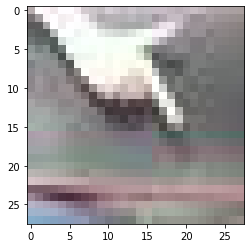

예측확률분포: [0.32722247 0.04421585 0.6285617 ]
라벨: 0, 예측결과: 2


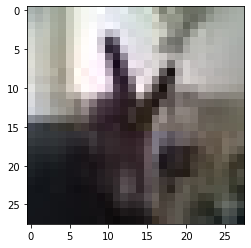

예측확률분포: [0.20406637 0.7451638  0.05076981]
라벨: 0, 예측결과: 1


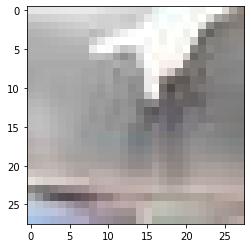

예측확률분포: [0.08501438 0.31932563 0.59566003]
라벨: 1, 예측결과: 2


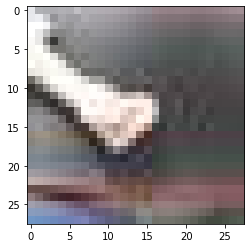

예측확률분포: [0.20756423 0.37158358 0.4208522 ]
라벨: 0, 예측결과: 2


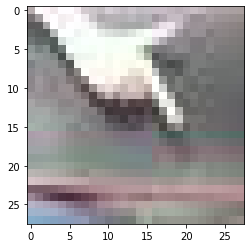

In [2]:
### 테스트 데이터 로딩. 
paper_dir_path = r"C:\Users\user\Google 드라이브\AIFFEL\Day7\odd_set\paper"    
rock_dir_path = r"C:\Users\user\Google 드라이브\AIFFEL\Day7\odd_set\rock"    
scissor_dir_path = r"C:\Users\user\Google 드라이브\AIFFEL\Day7\odd_set\scissor"    

resize_images(paper_dir_path)
print("보 이미지 resize 완료!")
resize_images(rock_dir_path)
print("바위 이미지 resize 완료!")
resize_images(scissor_dir_path)
print("가위 이미지 resize 완료!")


testimage_dir_path = r"C:\Users\user\Google 드라이브\AIFFEL\Day7\odd_set"
(x_test, y_test)=load_data(testimage_dir_path)
x_test_norm = x_test/255.0

print("Before Reshape - x_test_norm shape: {}". format(x_test_norm.shape))

x_test_reshaped = x_test_norm.reshape(-1, resize_factor, resize_factor, 3)
print("After Reshape - x_test_reshaped shape: {}".format(x_test_reshaped.shape))

### 모델 시험평가
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose = 2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

### 평가 결과 피드백
# model.predict()는 model이 입력값을 보고 실제로 추론한 확률분포를 출력함.
predicted_result = model.predict(x_test_reshaped) # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0   # 1번째 x_test
print('model.predict() 결과: ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 :', y_test[idx])

### 오류 확인
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모음.
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)
        
# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population = wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n])+ ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

### 하이퍼 파라미터 변경 및 최적화 (3/3)

In [3]:
### Try number: 1
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation ='relu', input_shape=(resize_factor,resize_factor,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

model.summary()
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs = n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose = 2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 32)               

In [4]:
### Try number: 2
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=15

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation ='relu', input_shape=(resize_factor,resize_factor,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

model.summary()
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs = n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose = 2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 800)               0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [5]:
# Try number : 3
n_channel_1=16
n_channel_2=32
n_dense=64
n_train_epoch=15

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation ='relu', input_shape=(resize_factor,resize_factor,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

model.summary()
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs = n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose = 2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 800)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [6]:
# Try number : 4
n_channel_1=32
n_channel_2=64
n_dense=32
n_train_epoch=15

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation ='relu', input_shape=(resize_factor,resize_factor,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

model.summary()
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs = n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose = 2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [7]:
# Try number : 5
n_channel_1=32
n_channel_2=64
n_dense=128
n_train_epoch=15

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation ='relu', input_shape=(resize_factor,resize_factor,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

model.summary()
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs = n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose = 2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1600)              0         
                                                                 
 dense_10 (Dense)            (None, 128)              

## 결론
#### 나의 데이터에 대해, 여기에는 넣지 않았으나 대부분 흰색인 일반 배경으로 찍은 사진은 28x28로 축소시 구분되지 않음.
#### 이에 배경을 검은색으로 하고 재촬영함. 연습시 테스트 셋은 훈련 셋과 동일하게 설정. 정확도 100% 나옴.
#### 하지만 overfit 여부는 알 근거가 없으므로 테스트셋을 다른 사람의 것으로 놓고 해보았다.

#### 모델 재훈련은 총 5회 실시하였다.
#### 재훈련 1 조건: n_channel_1=16, n_channel_2=32, n_dense=32, n_train_epoch=10
#### 재훈련 2 조건: n_channel_1=16, n_channel_2=32, n_dense=32, n_train_epoch=15
#### 재훈련 3 조건: n_channel_1=16, n_channel_2=32, n_dense=64, n_train_epoch=15
#### 재훈련 4 조건: n_channel_1=16, n_channel_2=32, n_dense=64, n_train_epoch=15
#### 재훈련 5 조건: n_channel_1=32, n_channel_2=64, n_dense=128, n_train_epoch=15
#### 결과가 10~30%수준으로 만족스럽지 않아 다른 조원들과 대화한 결과, 리사이즈 스케일을 높여 112x112정도로 했더니 좋은 결과가 나왔다는 답변을 들었음
#### 이에 추가실험을 수행하였다.




### resize_factor: 112로 했을 때
### train data: Cham
### test data: KDY
#### n_channel_1=16, n_channel_2=32, n_dense=32, n_train_epoch=15 에서 
#### 최고 test_accuracy: 3차에서 55%
#### resize factor를 28, 56으로 했을 때보다 최고치는 약 20% 가량 높았다. 하지만 평가 기준에 도달하지는 못했다.

## resize_factor: 112
### train data: Cham, KDY (이름 변경 후 수동 혼합)
### test data: OCH
#### 1차에서 16.33%가 나옴. 이후는 점점 떨어짐. overfitting으로 생각됨.


## resize_factor: 112
### train data: Cham, KDY의 짝수 셋(수동 분류)
### test data: Cham, KDY의 홀수 셋(수동 분류)
#### 구글에서 이미지 획득시, 한 번 클릭할 때 빠른 속도로 촬영했던 것을 기억해내고 앞뒤 사진 간에는 큰 차이가 없을 것으로 생각되어 같은 데이터셋에서 훈련셋과 테스트셋을 홀짝으로 분류하였다. 
#### 첫 재훈련부터 99.67%가 나옴. 이후는 모두 100% 나옴.
#### 따라서 여기서 100%가 나오는 것은 overfit이 아닐 것으로 생각된다. 오류 데이터 검증도 5개를 채우지 못해 에러메시지를 출력하였다.

## resize_factor: 56
### train data: Cham, KDY의 짝수 셋(수동 분류)
### test data: Cham, KDY의 홀수 셋(수동 분류)

#### 첫 재훈련에서 86%가 나오고 점차 증가. 마지막 5차에서는 100%가 나왔다.

## resize_factor: 28
### train data: Cham, KDY의 짝수 셋(수동 분류)
### test data: Cham, KDY의 홀수 셋(수동 분류)

#### 1차에서 78.33%가 나오고 점차 증가. 마지막 5차에서는 97%가 나왔다.

## 결론
#### 1. 원본 촬영시 타겟이 배경의 대비차를 높도록 촬영하면 정확도는 증가한다.
#### 2. 해상도가 높으면 구분이 잘되므로정확도는 증가한다. 
#### 3. 하이퍼 파라미터들은 늘릴수록 좋은 편이나 원본이 좋지 않을 경우 overfitting이 있는 것으로 생각된다. 상세 이유는 이후 공부가 필요할 것으로 보임.


## 회고
#### 1. 데이터를 섞고, 훈련/검증/시험 데이터를 나누는 게 쉽지 않았다. 수동으로 진행하였으며, 검증셋은 빼고 진행하였다.
#### 2. 하이퍼 파라미터를 변경해 가면서 돌리고 그 결과만 내는 걸 for 문으로 돌리면 좋을 것 같은데.. 구상하다 시간만 갔다.
#### 3. 원본데이터의 허점이 있어 높은 정확도를 달성할 수 있었다. 하지만 그렇지 않다면.. 쉽지 않을 듯.